## Analysis-of-PC-Component-Purchases

In [ ]:
%pip install pandas
%pip install mlxtend


#### Import and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


#### Load Data

In [2]:
DATA_PATH = "../data/expanded_pc_build_data.csv"

df_raw = pd.read_csv(DATA_PATH, index_col=0)

df_raw.head()


,user_id,transaction_id,person,date,city,purchased_items
0,USER0001,TX00001,Michele Griffin,2022-11-20,"Houston, TX","External HDD,CPU,USB Hub,Keyboard,Mouse,Power ..."
1,USER0001,TX00002,Michele Griffin,2024-07-04,"Houston, TX","Motherboard,Thermal Paste,UPS,Graphics Tablet"
2,USER0001,TX00003,Michele Griffin,2022-10-18,"Houston, TX","CPU,Motherboard,Surge Protector,GPU,Cooling Fa..."
3,USER0002,TX00004,Lisa Christian,2024-05-31,"Detroit, MI","Power Supply,External HDD,Sound Card,Speakers"
4,USER0002,TX00005,Lisa Christian,2022-10-18,"Detroit, MI","Thermal Paste,CPU,Surge Protector,Motherboard,..."


#### Data Cleaning & Transformation (ETL)

In [3]:
# Convert comma-separated strings into clean Python lists
df_raw["purchased_items"] = (
    df_raw["purchased_items"]
    .str.split(",")
    .apply(lambda items: [item.strip() for item in items])
)

df_raw["purchased_items"].head()


0    [External HDD, CPU, USB Hub, Keyboard, Mouse, ...
1    [Motherboard, Thermal Paste, UPS, Graphics Tab...
2    [CPU, Motherboard, Surge Protector, GPU, Cooli...
3    [Power Supply, External HDD, Sound Card, Speak...
4    [Thermal Paste, CPU, Surge Protector, Motherbo...
Name: purchased_items, dtype: object

In [4]:
df_raw.info()
df_raw["purchased_items"].iloc[0]


<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          10000 non-null  str   
 1   transaction_id   10000 non-null  str   
 2   person           10000 non-null  str   
 3   date             10000 non-null  str   
 4   city             10000 non-null  str   
 5   purchased_items  10000 non-null  object
dtypes: object(1), str(5)
memory usage: 468.9+ KB


['External HDD',
 'CPU',
 'USB Hub',
 'Keyboard',
 'Mouse',
 'Power Supply',
 'Headset',
 'Optical Drive']

#### Transaction Encoding (One-Hot Encoding)

In [5]:
# Extract transactions
transactions = df_raw["purchased_items"].tolist()

# Initialize and apply TransactionEncoder
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

# Create encoded DataFrame
df_encoded = pd.DataFrame(te_array, columns=te.columns_)
df_encoded.head()


,CPU,CPU Cooler,Case,Cooling Fan,External HDD,GPU,Graphics Tablet,HDD,Headset,Keyboard,...,RAM,RGB Lighting,SSD,Sound Card,Speakers,Surge Protector,Thermal Paste,UPS,USB Hub,Webcam
0,True,False,False,False,True,False,False,False,True,True,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,True,False,False
2,True,False,False,True,False,True,False,False,True,True,...,False,False,False,False,True,True,False,True,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
4,True,True,False,True,False,False,True,True,False,False,...,False,False,False,True,False,True,True,False,False,False


#### Frequent Itemset Mining (Apriori)

In [21]:
frequent_itemsets = apriori(
    df_encoded,
    min_support=0.02,
    use_colnames=True
)

frequent_itemsets.sort_values("support", ascending=False).head(10)

,support,itemsets
7,0.2609,frozenset({HDD})
8,0.2547,frozenset({Headset})
16,0.2546,frozenset({RAM})
9,0.2538,frozenset({Keyboard})
22,0.2532,frozenset({Thermal Paste})
24,0.2529,frozenset({USB Hub})
17,0.2529,frozenset({RGB Lighting})
18,0.2528,frozenset({SSD})
3,0.2528,frozenset({Cooling Fan})
1,0.2521,frozenset({CPU Cooler})


#### Association Rule Generation

In [22]:
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.2
)


In [23]:
rules = rules[
    (rules["lift"] > 1) 
]


#### Rule Analysis & Ranking

In [24]:
# Top 10 Rules by Lift
rules.sort_values("lift", ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
661,"frozenset({Keyboard, Power Supply})",frozenset({USB Hub}),0.0646,0.2529,0.0205,0.317337,1.254794,1.0,0.004163,1.094391,0.217080,0.069024,0.086250,0.199199
652,"frozenset({Surge Protector, CPU Cooler})",frozenset({Monitor}),0.0643,0.2504,0.0200,0.311042,1.242180,1.0,0.003899,1.088020,0.208362,0.067866,0.080899,0.195457
650,"frozenset({Monitor, Surge Protector})",frozenset({CPU Cooler}),0.0648,0.2521,0.0200,0.308642,1.224284,1.0,0.003664,1.081784,0.195890,0.067363,0.075601,0.193988
659,"frozenset({USB Hub, Keyboard})",frozenset({Power Supply}),0.0671,0.2505,0.0205,0.305514,1.219617,1.0,0.003691,1.079216,0.193023,0.069000,0.073401,0.193675
657,"frozenset({USB Hub, HDD})",frozenset({Surge Protector}),0.0679,0.2513,0.0206,0.303387,1.207272,1.0,0.003537,1.074772,0.184193,0.068989,0.069570,0.192681
651,"frozenset({Monitor, CPU Cooler})",frozenset({Surge Protector}),0.0667,0.2513,0.0200,0.299850,1.193196,1.0,0.003238,1.069342,0.173486,0.067114,0.064846,0.189718
653,"frozenset({Headset, HDD})",frozenset({Cooling Fan}),0.0666,0.2528,0.0200,0.300300,1.187897,1.0,0.003164,1.067887,0.169462,0.066800,0.063571,0.189707
658,"frozenset({Surge Protector, HDD})",frozenset({USB Hub}),0.0686,0.2529,0.0206,0.300292,1.187392,1.0,0.003251,1.067730,0.169442,0.068461,0.063434,0.190873
656,"frozenset({USB Hub, Surge Protector})",frozenset({HDD}),0.0680,0.2609,0.0206,0.302941,1.161139,1.0,0.002859,1.060312,0.148902,0.066818,0.056882,0.190949
655,"frozenset({HDD, Cooling Fan})",frozenset({Headset}),0.0682,0.2547,0.0200,0.293255,1.151375,1.0,0.002629,1.054553,0.141096,0.066028,0.051731,0.185889


In [25]:
# Top 10 Rules by Confidence
rules.sort_values("confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
661,"frozenset({Keyboard, Power Supply})",frozenset({USB Hub}),0.0646,0.2529,0.0205,0.317337,1.254794,1.0,0.004163,1.094391,0.217080,0.069024,0.086250,0.199199
652,"frozenset({Surge Protector, CPU Cooler})",frozenset({Monitor}),0.0643,0.2504,0.0200,0.311042,1.242180,1.0,0.003899,1.088020,0.208362,0.067866,0.080899,0.195457
650,"frozenset({Monitor, Surge Protector})",frozenset({CPU Cooler}),0.0648,0.2521,0.0200,0.308642,1.224284,1.0,0.003664,1.081784,0.195890,0.067363,0.075601,0.193988
659,"frozenset({USB Hub, Keyboard})",frozenset({Power Supply}),0.0671,0.2505,0.0205,0.305514,1.219617,1.0,0.003691,1.079216,0.193023,0.069000,0.073401,0.193675
657,"frozenset({USB Hub, HDD})",frozenset({Surge Protector}),0.0679,0.2513,0.0206,0.303387,1.207272,1.0,0.003537,1.074772,0.184193,0.068989,0.069570,0.192681
656,"frozenset({USB Hub, Surge Protector})",frozenset({HDD}),0.0680,0.2609,0.0206,0.302941,1.161139,1.0,0.002859,1.060312,0.148902,0.066818,0.056882,0.190949
653,"frozenset({Headset, HDD})",frozenset({Cooling Fan}),0.0666,0.2528,0.0200,0.300300,1.187897,1.0,0.003164,1.067887,0.169462,0.066800,0.063571,0.189707
658,"frozenset({Surge Protector, HDD})",frozenset({USB Hub}),0.0686,0.2529,0.0206,0.300292,1.187392,1.0,0.003251,1.067730,0.169442,0.068461,0.063434,0.190873
654,"frozenset({Headset, Cooling Fan})",frozenset({HDD}),0.0667,0.2609,0.0200,0.299850,1.149291,1.0,0.002598,1.055631,0.139182,0.065020,0.052699,0.188254
651,"frozenset({Monitor, CPU Cooler})",frozenset({Surge Protector}),0.0667,0.2513,0.0200,0.299850,1.193196,1.0,0.003238,1.069342,0.173486,0.067114,0.064846,0.189718


In [26]:
# Improve Interpretability
rules["antecedents"] = rules["antecedents"].apply(lambda x: ", ".join(list(x)))
rules["consequents"] = rules["consequents"].apply(lambda x: ", ".join(list(x)))

rules.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,CPU,CPU Cooler,0.2515,0.2521,0.0635,0.252485,1.001528,1.0,0.000097,1.000515,0.002038,0.144285,0.000515,0.252185
1,CPU Cooler,CPU,0.2521,0.2515,0.0635,0.251884,1.001528,1.0,0.000097,1.000514,0.002039,0.144285,0.000513,0.252185
2,CPU,Case,0.2515,0.2474,0.0646,0.256859,1.038233,1.0,0.002379,1.012728,0.049199,0.148745,0.012568,0.258987
3,Case,CPU,0.2474,0.2515,0.0646,0.261116,1.038233,1.0,0.002379,1.013014,0.048930,0.148745,0.012846,0.258987
4,CPU,Cooling Fan,0.2515,0.2528,0.0638,0.253678,1.003473,1.0,0.000221,1.001176,0.004624,0.144835,0.001175,0.253026


#### Visualization

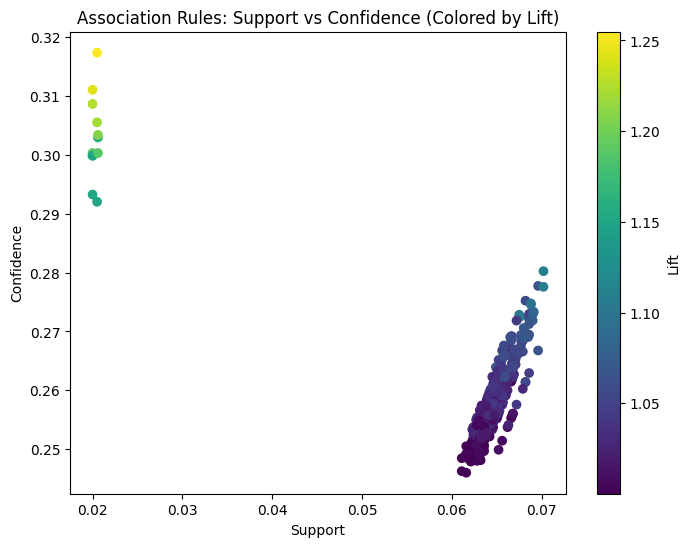

In [27]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    rules["support"],
    rules["confidence"],
    c=rules["lift"],
    cmap="viridis"
)

plt.colorbar(scatter, label="Lift")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules: Support vs Confidence (Colored by Lift)")
plt.show()


In [28]:
# Sanity Check
print(f"Total Transactions: {len(transactions)}")
print(f"Frequent Itemsets: {len(frequent_itemsets)}")
print(f"Association Rules: {len(rules)}")


Total Transactions: 10000
Frequent Itemsets: 355
Association Rules: 428
